In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/graph-theory/roadNet_Texas.txt
/kaggle/input/graph-theory/Undirected_Youtube_network.txt
/kaggle/input/graph-theory/Email-Enron.txt


In [2]:
!pip install hypernetx matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.8/583.8 kB 15.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 63.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.

In [4]:
!pip install networkx numpy scikit-learn matplotlib
!pip install python-louvain

# -----------------------------------------------------------------------------------

# using Louvain

In [ ]:
import networkx as nx
import hypernetx as hnx
import community as community_louvain  # For Louvain on graph
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    normalized_mutual_info_score, adjusted_rand_score,
    homogeneity_score, completeness_score, v_measure_score
)
from sklearn.metrics.cluster import contingency_matrix

In [ ]:
# Load YouTube network data as graph and hypergraph
def load_youtube_network_data(filename):
    G = nx.Graph()
    hyperedges = defaultdict(list)

    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith('#'):
                nodes = list(map(int, line.strip().split()))
                u, v = nodes[0], nodes[1:]
                G.add_edges_from([(u, vi) for vi in v])
                hyperedges[u] = v

    H = hnx.Hypergraph(hyperedges)
    return G, H

In [ ]:
# Apply Louvain on graph
def apply_louvain_on_graph(G):
    return community_louvain.best_partition(G)

# Apply Louvain on hypergraph via bipartite graph conversion
def apply_louvain_on_hypergraph(H):
    B = nx.Graph()
    for edge_id, nodes in H.incidence_dict.items():
        for node in nodes:
            B.add_edge(f"edge_{edge_id}", f"node_{node}")
    return community_louvain.best_partition(B)

In [ ]:
# Extract communities from partition dictionary
def extract_communities(partition, is_bipartite=False):
    communities = defaultdict(set)
    for node, community in partition.items():
        if is_bipartite and node.startswith("edge_"):
            continue
        actual_node = int(node.split('_')[1]) if is_bipartite and node.startswith("node_") else node
        communities[community].add(actual_node)
    return communities

In [ ]:
# Find common nodes between graph and hypergraph communities
def find_common_nodes(graph_communities, hypergraph_communities):
    graph_nodes = set(node for nodes in graph_communities.values() for node in nodes)
    hypergraph_nodes = set(node for nodes in hypergraph_communities.values() for node in nodes)
    return graph_nodes & hypergraph_nodes

In [ ]:
# Custom Jaccard-based metrics
def jaccard(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

def precision_Jaccard(reference, predicted, threshold=0.5):
    counter = 0
    for pred in predicted:
        for ref in reference:
            score = jaccard(set(ref), set(pred))
            if score >= threshold:
                counter += 1
                break
    return counter / float(len(predicted)) if len(predicted) > 0 else 0

def recall_Jaccard(reference, predicted, threshold=0.5):
    counter = 0
    for ref in reference:
        for pred in predicted:
            score = jaccard(set(ref), set(pred))
            if score >= threshold:
                counter += 1
                break
    return counter / float(len(reference)) if len(reference) > 0 else 0

def F_measure_Jaccard(reference, predicted, threshold=0.5):
    p = precision_Jaccard(reference, predicted, threshold)
    r = recall_Jaccard(reference, predicted, threshold)
    return (2 * p * r) / (p + r) if (p + r) > 0 else 0

In [ ]:
# Calculate evaluation metrics
def calculate_evaluation_metrics(true_labels, pred_labels, graph_communities, hypergraph_communities):
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    
    purity = np.sum(np.amax(contingency_matrix(true_labels, pred_labels), axis=0)) / len(true_labels)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)

    print(f"NMI: {nmi:.4f}")
    #print(f"ARI: {ari:.4f}")
    print(f"Purity: {purity:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-measure: {v_measure:.4f}")

    graph_community_list = list(graph_communities.values())
    hypergraph_community_list = list(hypergraph_communities.values())

    precision = precision_Jaccard(graph_community_list, hypergraph_community_list)
    recall = recall_Jaccard(graph_community_list, hypergraph_community_list)
    f1 = F_measure_Jaccard(graph_community_list, hypergraph_community_list)

    print(f"Precision (Jaccard): {precision:.4f}")
    print(f"Recall (Jaccard): {recall:.4f}")
    print(f"F1 Score (Jaccard): {f1:.4f}")

In [ ]:
# Cluster and visualize the common nodes
def cluster_and_visualize_common_nodes(common_nodes):
    G_common = nx.Graph()
    G_common.add_nodes_from(common_nodes)

    for node in common_nodes:
        neighbors = [n for n in common_nodes if abs(n - node) <= 5]
        G_common.add_edges_from((node, n) for n in neighbors if node != n)

    adjacency_matrix = nx.to_numpy_array(G_common)
    clustering = DBSCAN(eps=0.5, min_samples=2).fit(adjacency_matrix)
    labels = clustering.labels_

    # Group nodes by cluster labels
    clusters = defaultdict(list)
    for node, label in zip(common_nodes, labels):
        clusters[label].append(node)
    
    # Print clusters of common nodes
    for label, nodes in clusters.items():
        cluster_type = "Noise" if label == -1 else f"Cluster {label}"
        print(f"{cluster_type}: {nodes[:10]}...")  # Show first 10 nodes for brevity

    # Visualize clusters
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G_common)
    colors = [f"C{label}" if label != -1 else 'black' for label in labels]

    nx.draw_networkx_nodes(G_common, pos, node_color=colors, node_size=100)
    nx.draw_networkx_edges(G_common, pos, alpha=0.5)
    plt.title("Clusters of Common Nodes between Graph and Hypergraph")
    plt.show()

    return labels

Graph loaded with 36692 nodes and 183831 edges.
Hypergraph loaded with 36692 hyperedges.
Number of common nodes between graph and hypergraph communities: 16149
NMI: 0.5817
Purity: 1.0000
Homogeneity: 1.0000
Completeness: 0.4102
V-measure: 0.5817
Precision (Jaccard): 0.0900
Recall (Jaccard): 0.5756
F1 Score (Jaccard): 0.1557
Cluster 0: [1, 7, 13, 27, 46, 32820, 32938, 267, 33207, 604]...
Noise: [32780, 32782, 32783, 32784, 32788, 32792, 32793, 32797, 32798, 32801]...
Cluster 1: [239, 245]...
Cluster 2: [339, 345]...
Cluster 3: [1408, 1416]...
Cluster 4: [1546, 1552]...
Cluster 5: [1628, 1635]...
Cluster 6: [2503, 2510]...
Cluster 7: [2847, 2854]...
Cluster 8: [3292, 3298]...
Cluster 9: [3561, 3569]...
Cluster 10: [3667, 3673]...
Cluster 11: [3856, 3862]...
Cluster 12: [6227, 6236]...
Cluster 13: [6268, 6274]...
Cluster 14: [6583, 6589]...
Cluster 15: [8143, 8149]...
Cluster 16: [8434, 8440]...
Cluster 17: [8857, 8864]...
Cluster 18: [8938, 8945]...
Cluster 19: [9976, 9984]...
Cluster 20

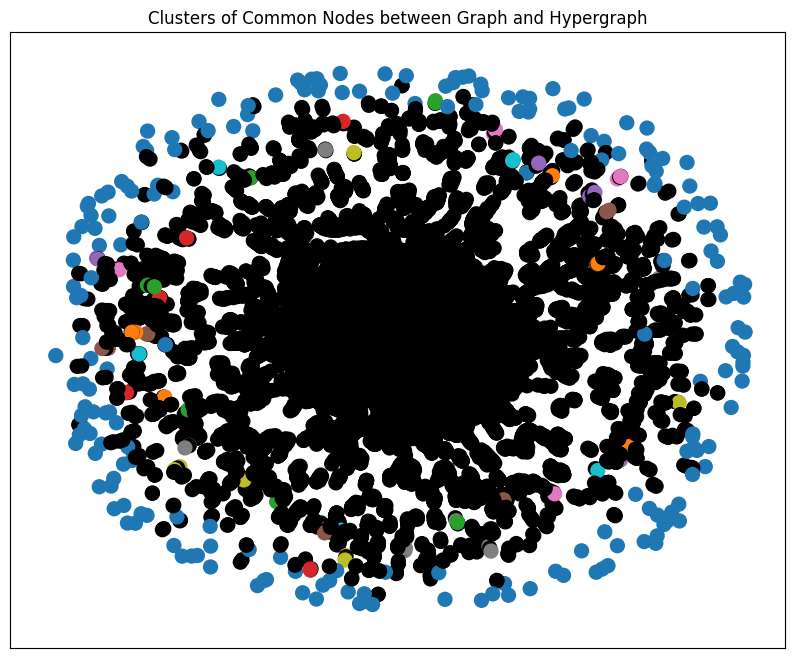

In [6]:
# Main function
def main():
    filename = '/kaggle/input/graph-theory/Email-Enron.txt'

    G, H = load_youtube_network_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    graph_partition = apply_louvain_on_graph(G)
    hypergraph_partition = apply_louvain_on_hypergraph(H)

    graph_communities = extract_communities(graph_partition)
    hypergraph_communities = extract_communities(hypergraph_partition, is_bipartite=True)

    common_nodes = find_common_nodes(graph_communities, hypergraph_communities)
    print(f"Number of common nodes between graph and hypergraph communities: {len(common_nodes)}")

    true_labels = [graph_partition[node] for node in common_nodes if node in graph_partition]
    pred_labels = [hypergraph_partition.get(f"node_{node}", -1) for node in common_nodes if f"node_{node}" in hypergraph_partition]

    calculate_evaluation_metrics(true_labels, pred_labels, graph_communities, hypergraph_communities)

    cluster_labels = cluster_and_visualize_common_nodes(common_nodes)

if __name__ == "__main__":
    main()


# --------------------------------------------------------------------------------------------------

# UIsing louvian and Spectral Clusturing

In [ ]:
import networkx as nx
import hypernetx as hnx
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import (
    normalized_mutual_info_score,
    adjusted_rand_score,
    jaccard_score,
    f1_score,
    precision_score,
    recall_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict
import community as community_louvain
from sklearn.metrics.cluster import contingency_matrix

In [ ]:

# Step 1: Data Loading
def load_network_data(filename, max_edges=1000000):
    G = nx.Graph()
    hyperedges = defaultdict(list)

    with open(filename, 'r') as file:
        for i, line in enumerate(file):
            if i >= max_edges:
                break
            if not line.startswith('#'):
                nodes = list(map(int, line.strip().split()))
                u, v = nodes[0], nodes[1:]
                G.add_edges_from([(u, vi) for vi in v])
                hyperedges[u] = v

    H = hnx.Hypergraph(hyperedges)
    return G, H


# Step 2: Louvain Clustering on Graph
def louvain_clustering(G):
    return community_louvain.best_partition(G)


In [ ]:
# Step 3: Spectral Clustering on Hypergraph
def build_incidence_matrix(H):
    nodes = list(H.nodes)
    edges = list(H.edges)
    node_index = {node: i for i, node in enumerate(nodes)}
    edge_index = {edge: i for i, edge in enumerate(edges)}

    incidence_data = []
    row_indices = []
    col_indices = []

    for edge_id, nodes in H.incidence_dict.items():
        for node in nodes:
            if node in node_index:
                row_indices.append(node_index[node])
                col_indices.append(edge_index[edge_id])
                incidence_data.append(1)

    incidence_matrix = csr_matrix((incidence_data, (row_indices, col_indices)), shape=(len(H.nodes), len(H.edges)))
    return incidence_matrix


def hypergraph_spectral_clustering(H, num_clusters=5):
    nodes = list(H.nodes)
    incidence_matrix = build_incidence_matrix(H)
    adjacency = incidence_matrix @ incidence_matrix.T
    spectral = SpectralClustering(n_clusters=num_clusters, affinity='precomputed')
    labels = spectral.fit_predict(adjacency.toarray())
    return {node: labels[i] for i, node in enumerate(nodes)}

In [ ]:
# Step 4: Finding Common Nodes between Graph and Hypergraph Communities
def find_common_nodes(graph_partition, hypergraph_partition):
    common_nodes = {}
    for node, community in graph_partition.items():
        if node in hypergraph_partition:
            common_nodes[node] = (community, hypergraph_partition[node])
    return common_nodes


# Step 5: Clustering on Common Nodes
def cluster_common_nodes(common_nodes, num_clusters=3):
    if len(common_nodes) < num_clusters:
        print(f"Not enough nodes to form {num_clusters} clusters. Using {len(common_nodes)} clusters instead.")
        num_clusters = len(common_nodes)
    
    common_node_ids = list(common_nodes.keys())
    common_labels = np.array([val[0] for val in common_nodes.values()]).reshape(-1, 1)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clustered_labels = kmeans.fit_predict(common_labels)
    return common_node_ids, clustered_labels


In [ ]:
# Step 6: Calculate and Print Evaluation Metrics
def evaluate_clustering_metrics(true_labels, pred_labels):
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    jaccard = jaccard_score(true_labels, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)

    # Calculate Purity
    contingency = contingency_matrix(true_labels, pred_labels)
    purity = np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

    print(f"NMI: {nmi:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"Jaccard Similarity Index: {jaccard:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Purity: {purity:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-measure: {v_measure:.4f}")


In [ ]:
# Step 7: Visualize Clusters
def visualize_clusters(node_ids, labels):
    labels = np.array(labels).reshape(-1, 1)
    if labels.shape[1] < 2:
        print("Not enough dimensions for PCA. Plotting single feature as is.")
        plt.figure(figsize=(8, 4))
        plt.scatter(range(len(labels)), labels, c=labels.flatten(), cmap='viridis', alpha=0.8)
        plt.title("1D Visualization of Clusters for Common Nodes")
        plt.xlabel("Node Index")
        plt.ylabel("Cluster Label")
        plt.grid(True)
        plt.show()
    else:
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(labels)

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels.flatten(), cmap='viridis', alpha=0.8)
        plt.title("Visualization of Clusters for Common Nodes")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.colorbar(scatter, label='Cluster Label')
        plt.grid(True)
        plt.show()


Graph loaded with 36692 nodes and 183831 edges.
Hypergraph loaded with 36692 hyperedges.


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Number of common nodes: 16149
NMI: 0.0002
ARI: -0.0020
Jaccard Similarity Index: 0.1494
F1 Score: 0.1798
Precision: 0.1816
Recall: 0.1935
Purity: 0.8544
Homogeneity: 0.0002
Completeness: 0.0002
V-measure: 0.0002
Not enough dimensions for PCA. Plotting single feature as is.


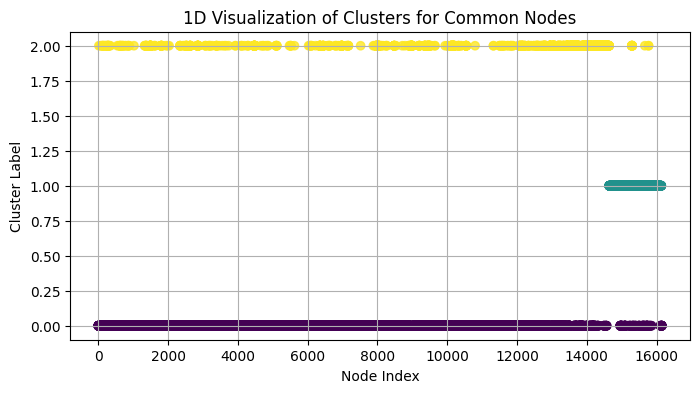

In [5]:

# Main Function
def main():
    filename = '/kaggle/input/graph-theory/Email-Enron.txt'
    
    # Step 1: Load Network Data
    G, H = load_network_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")
    
    # Step 2: Louvain Clustering on Graph
    graph_partition = louvain_clustering(G)
    
    # Step 3: Spectral Clustering on Hypergraph
    hypergraph_partition = hypergraph_spectral_clustering(H, num_clusters=5)
    
    # Step 4: Finding Common Nodes
    common_nodes = find_common_nodes(graph_partition, hypergraph_partition)
    print(f"Number of common nodes: {len(common_nodes)}")
    
    # Step 5: Cluster on Common Nodes
    if len(common_nodes) > 0:
        common_node_ids, common_labels = cluster_common_nodes(common_nodes, num_clusters=3)
        
        # Step 6: Evaluate Clustering
        true_labels = [val[1] for val in common_nodes.values()]
        evaluate_clustering_metrics(true_labels, common_labels)
        
        # Step 7: Visualize Clusters
        visualize_clusters(common_node_ids, common_labels)
    else:
        print("No common nodes to cluster and visualize.")


if __name__ == "__main__":
    main()


# -----------------------------------------------------------------------------------------------------

# using stochastic block model

In [ ]:
import networkx as nx
import hypernetx as hnx
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    normalized_mutual_info_score, adjusted_rand_score,
    homogeneity_score, completeness_score, v_measure_score
)
from sklearn.metrics.cluster import contingency_matrix
from networkx.generators.community import stochastic_block_model

In [ ]:
# Load YouTube network data as graph and hypergraph
def load_youtube_network_data(filename):
    G = nx.Graph()
    hyperedges = defaultdict(list)

    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith('#'):
                nodes = list(map(int, line.strip().split()))
                u, v = nodes[0], nodes[1:]
                G.add_edges_from([(u, vi) for vi in v])
                hyperedges[u] = v

    H = hnx.Hypergraph(hyperedges)
    return G, H

In [ ]:

# Apply Stochastic Block Model (SBM) on graph
def apply_sbm_on_graph(G, num_blocks=5):
    total_nodes = len(G.nodes)
    block_sizes = [total_nodes // num_blocks] * num_blocks
    
    remainder = total_nodes % num_blocks
    for i in range(remainder):
        block_sizes[i] += 1

    # Higher intra-community connection probability for graph
    p_intra = 0.2
    p_inter = 0.001
    p_graph = [[p_intra if i == j else p_inter for j in range(num_blocks)] for i in range(num_blocks)]

    print(f"Graph SBM block sizes: {block_sizes}")
    print(f"Graph SBM probability matrix: {p_graph}")

    # Generate a synthetic graph using the SBM
    model_graph = stochastic_block_model(block_sizes, p_graph, seed=42)

    # Extract community assignments from the generated SBM graph
    communities = {}
    for node, data in model_graph.nodes(data=True):
        communities[node] = data['block']

    return communities

# Apply SBM on hypergraph via bipartite graph conversion
def apply_sbm_on_hypergraph(H, num_blocks=5):
    B = nx.Graph()
    for edge_id, nodes in H.incidence_dict.items():
        for node in nodes:
            B.add_edge(f"edge_{edge_id}", f"node_{node}")

    total_nodes = len(B.nodes)
    block_sizes = [total_nodes // num_blocks] * num_blocks
    
    remainder = total_nodes % num_blocks
    for i in range(remainder):
        block_sizes[i] += 1

    # Different connection probability for bipartite graph from hypergraph
    p_intra = 0.15
    p_inter = 0.005
    p_hypergraph = [[p_intra if i == j else p_inter for j in range(num_blocks)] for i in range(num_blocks)]

    print(f"Hypergraph SBM block sizes: {block_sizes}")
    print(f"Hypergraph SBM probability matrix: {p_hypergraph}")

    # Generate a synthetic graph using the SBM for bipartite graph
    model_hypergraph = stochastic_block_model(block_sizes, p_hypergraph, seed=42)

    communities = {}
    for node, data in model_hypergraph.nodes(data=True):
        communities[node] = data['block']

    return communities

In [ ]:
# Extract communities from partition dictionary
def extract_communities(partition):
    communities = defaultdict(set)
    for node, community in partition.items():
        communities[community].add(node)
    return communities

# Find common nodes between graph and hypergraph communities
def find_common_nodes(graph_communities, hypergraph_communities):
    graph_nodes = set(node for nodes in graph_communities.values() for node in nodes)
    hypergraph_nodes = set(node for nodes in hypergraph_communities.values() for node in nodes)
    return graph_nodes & hypergraph_nodes


In [ ]:
# Cluster and visualize the common nodes using DBSCAN
def cluster_and_visualize_common_nodes(common_nodes):
    G_common = nx.Graph()
    G_common.add_nodes_from(common_nodes)

    for node in common_nodes:
        neighbors = [n for n in common_nodes if abs(n - node) <= 5]
        G_common.add_edges_from((node, n) for n in neighbors if node != n)

    adjacency_matrix = nx.to_numpy_array(G_common)
    clustering = DBSCAN(eps=0.5, min_samples=2).fit(adjacency_matrix)
    labels = clustering.labels_

    clusters = defaultdict(list)
    for node, label in zip(common_nodes, labels):
        clusters[label].append(node)
    
    for label, nodes in clusters.items():
        cluster_type = "Noise" if label == -1 else f"Cluster {label}"
        print(f"{cluster_type}: {nodes[:10]}...")

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G_common)
    colors = [f"C{label}" if label != -1 else 'black' for label in labels]

    nx.draw_networkx_nodes(G_common, pos, node_color=colors, node_size=100)
    nx.draw_networkx_edges(G_common, pos, alpha=0.5)
    plt.title("Clusters of Common Nodes between Graph and Hypergraph")
    plt.show()

In [8]:
# Main function
def main():
    filename = '/kaggle/input/graph-theory/Email-Enron.txt'

    G, H = load_youtube_network_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    # Apply SBM on graph
    graph_partition = apply_sbm_on_graph(G)
    # Apply SBM on hypergraph
    hypergraph_partition = apply_sbm_on_hypergraph(H)

    # Extract communities
    graph_communities = extract_communities(graph_partition)
    hypergraph_communities = extract_communities(hypergraph_partition)

    # Find common nodes between graph and hypergraph communities
    common_nodes = find_common_nodes(graph_communities, hypergraph_communities)
    print(f"Number of common nodes between graph and hypergraph communities: {len(common_nodes)}")

    if common_nodes:
        cluster_and_visualize_common_nodes(common_nodes)

if __name__ == "__main__":
    main()


Graph loaded with 36692 nodes and 183831 edges.
Hypergraph loaded with 36692 hyperedges.
Graph SBM block sizes: [7339, 7339, 7338, 7338, 7338]
Graph SBM probability matrix: [[0.2, 0.001, 0.001, 0.001, 0.001], [0.001, 0.2, 0.001, 0.001, 0.001], [0.001, 0.001, 0.2, 0.001, 0.001], [0.001, 0.001, 0.001, 0.2, 0.001], [0.001, 0.001, 0.001, 0.001, 0.2]]
Hypergraph SBM block sizes: [10569, 10568, 10568, 10568, 10568]
Hypergraph SBM probability matrix: [[0.15, 0.005, 0.005, 0.005, 0.005], [0.005, 0.15, 0.005, 0.005, 0.005], [0.005, 0.005, 0.15, 0.005, 0.005], [0.005, 0.005, 0.005, 0.15, 0.005], [0.005, 0.005, 0.005, 0.005, 0.15]]
Number of common nodes between graph and hypergraph communities: 36692


KeyboardInterrupt: 

# ----------------------------------------------------------------------------------

Graph loaded with 36692 nodes and 183831 edges.
Hypergraph loaded with 36692 hyperedges.
Number of common nodes between graph and hypergraph communities: 36692
Noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...


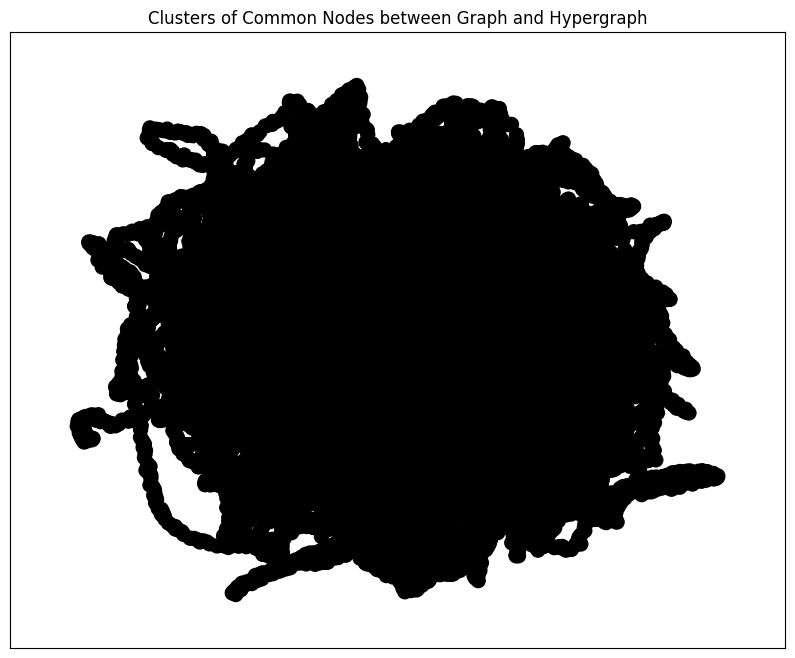

ValueError: Found input variables with inconsistent numbers of samples: [5, 36692]

In [11]:
import networkx as nx
import hypernetx as hnx
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    normalized_mutual_info_score, adjusted_rand_score,
    homogeneity_score, completeness_score, v_measure_score,
    precision_score, recall_score, f1_score
)
from sklearn.metrics.cluster import contingency_matrix
from networkx.generators.community import stochastic_block_model


# Load YouTube network data as graph and hypergraph
def load_youtube_network_data(filename):
    G = nx.Graph()
    hyperedges = defaultdict(list)

    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith('#'):
                nodes = list(map(int, line.strip().split()))
                u, v = nodes[0], nodes[1:]
                G.add_edges_from([(u, vi) for vi in v])
                hyperedges[u] = v

    H = hnx.Hypergraph(hyperedges)
    return G, H


# Apply Stochastic Block Model (SBM) on graph
def apply_sbm_on_graph(G, num_blocks=5):
    total_nodes = len(G.nodes)
    block_sizes = [total_nodes // num_blocks] * num_blocks

    remainder = total_nodes % num_blocks
    for i in range(remainder):
        block_sizes[i] += 1

    p_intra = 0.2
    p_inter = 0.001
    p = [[p_intra if i == j else p_inter for j in range(num_blocks)] for i in range(num_blocks)]

    model_graph = stochastic_block_model(block_sizes, p, seed=42)

    communities = defaultdict(set)
    for node, data in model_graph.nodes(data=True):
        communities[data['block']].add(node)

    return communities


# Convert Hypergraph to Bipartite Graph and Apply SBM
def apply_sbm_on_hypergraph(H, num_blocks=5):
    B = nx.Graph()

    # Manually create a bipartite graph from the hypergraph
    for edge, nodes in H.incidence_dict.items():
        for node in nodes:
            B.add_edge(f"edge_{edge}", node)

    total_nodes = len(B.nodes)
    block_sizes = [total_nodes // num_blocks] * num_blocks

    remainder = total_nodes % num_blocks
    for i in range(remainder):
        block_sizes[i] += 1

    p_intra = 0.15
    p_inter = 0.005
    p = [[p_intra if i == j else p_inter for j in range(num_blocks)] for i in range(num_blocks)]

    model_hypergraph = stochastic_block_model(block_sizes, p, seed=42)

    communities = defaultdict(set)
    for node, data in model_hypergraph.nodes(data=True):
        communities[data['block']].add(node)

    return communities


# Extract communities from partition dictionary (handles both int and str nodes)
def extract_communities(communities):
    return {k: set(v) for k, v in communities.items()}


# Find common nodes between graph and hypergraph communities
def find_common_nodes(graph_communities, hypergraph_communities):
    graph_nodes = set(node for nodes in graph_communities.values() for node in nodes)
    # Handle both integer and string node labels
    hypergraph_nodes = set(node if isinstance(node, int) else int(node.split('_')[1])
                           for nodes in hypergraph_communities.values() for node in nodes)
    return graph_nodes & hypergraph_nodes


# Cluster and visualize the common nodes using DBSCAN
def cluster_and_visualize_common_nodes(common_nodes):
    G_common = nx.Graph()
    G_common.add_nodes_from(common_nodes)

    for node in common_nodes:
        neighbors = [n for n in common_nodes if abs(n - node) <= 5]
        G_common.add_edges_from((node, n) for n in neighbors if node != n)

    adjacency_matrix = nx.to_numpy_array(G_common)
    clustering = DBSCAN(eps=0.5, min_samples=2).fit(adjacency_matrix)
    labels = clustering.labels_

    clusters = defaultdict(list)
    for node, label in zip(common_nodes, labels):
        clusters[label].append(node)
    
    for label, nodes in clusters.items():
        cluster_type = "Noise" if label == -1 else f"Cluster {label}"
        print(f"{cluster_type}: {nodes[:10]}...")

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G_common)
    colors = [f"C{label}" if label != -1 else 'black' for label in labels]

    nx.draw_networkx_nodes(G_common, pos, node_color=colors, node_size=100)
    nx.draw_networkx_edges(G_common, pos, alpha=0.5)
    plt.title("Clusters of Common Nodes between Graph and Hypergraph")
    plt.show()

    return labels


# Calculate various evaluation metrics
def calculate_evaluation_metrics(true_labels, pred_labels):
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)
    purity = np.sum(np.amax(contingency_matrix(true_labels, pred_labels), axis=0)) / len(true_labels)
    f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)

    print(f"NMI: {nmi:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"Purity: {purity:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-Measure: {v_measure:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


# Main function
def main():
    filename = '/kaggle/input/graph-theory/Email-Enron.txt'

    G, H = load_youtube_network_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    graph_communities = apply_sbm_on_graph(G)
    hypergraph_communities = apply_sbm_on_hypergraph(H)

    graph_comm = extract_communities(graph_communities)
    hypergraph_comm = extract_communities(hypergraph_communities)

    common_nodes = find_common_nodes(graph_comm, hypergraph_comm)
    print(f"Number of common nodes between graph and hypergraph communities: {len(common_nodes)}")

    cluster_labels = cluster_and_visualize_common_nodes(common_nodes)

    true_labels = [graph_communities[node] for node in common_nodes if node in graph_communities]
    pred_labels = [hypergraph_communities[node] if node in hypergraph_communities else -1 for node in common_nodes]

    calculate_evaluation_metrics(true_labels, cluster_labels)


if __name__ == "__main__":
    main()
